## Set-Up

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Define global variables
target_variable = 'AAPL'
lag_steps = 1

In [5]:
# Get Adj Close column
df_adjclose_aapl = pd.read_csv('../../data/clean/multimodal_inputs/baseline_transformed_dataset_AAPL.csv', header=0, index_col=0)
df_adjclose_aapl.head()

,AAPL(t-1),AAPL(t)
Date,,
2015-01-05,24.320435,23.635284
2015-01-06,23.635284,23.637510
2015-01-07,23.637510,23.968960
2015-01-08,23.968960,24.889904
2015-01-09,24.889904,24.916597


In [6]:
# Train-Test Split
split = int(df_adjclose_aapl.shape[0]*0.8)
train = df_adjclose_aapl[:split]
test = df_adjclose_aapl[split:]

print('Split Shape:', train.shape, test.shape)

Split Shape: (2011, 2) (503, 2)


In [8]:
# Scale to avoid distance calculation bias
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test) # Avoid data leakage

In [9]:
# Separate into features and target (first column)
X_train, y_train = train_scaled[:, :-1], train_scaled[:, -1]
X_test, y_test = test_scaled[:, :-1], test_scaled[:, -1]
print('Train Shape:', X_train.shape, y_train.shape)
print('Test Shape:', X_test.shape, y_test.shape)

Train Shape: (2011, 1) (2011,)
Test Shape: (503, 1) (503,)


## MLP

### Training

In [67]:
model = MLPRegressor(hidden_layer_sizes=(96), activation='relu', solver='adam', random_state=42, max_iter=30, verbose=True)
model.fit(X_train, y_train)

Iteration 1, loss = 0.02791191
Iteration 2, loss = 0.01272241
Iteration 3, loss = 0.00866348
Iteration 4, loss = 0.00504664
Iteration 5, loss = 0.00255925
Iteration 6, loss = 0.00122676
Iteration 7, loss = 0.00054785
Iteration 8, loss = 0.00025358
Iteration 9, loss = 0.00015880
Iteration 10, loss = 0.00013349
Iteration 11, loss = 0.00012867
Iteration 12, loss = 0.00012627
Iteration 13, loss = 0.00012391
Iteration 14, loss = 0.00012093
Iteration 15, loss = 0.00011812
Iteration 16, loss = 0.00011621
Iteration 17, loss = 0.00011359
Iteration 18, loss = 0.00011188
Iteration 19, loss = 0.00010901
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPRegressor(hidden_layer_sizes=96, max_iter=30, random_state=42, verbose=True)

### Predictions

In [68]:
# Get predicted values
yhat = model.predict(X_test)

# Inverse Scaling
y_test_rescaled = scaler.inverse_transform(np.column_stack((y_test, np.zeros_like(y_test))))[:, 0]
y_pred_rescaled = scaler.inverse_transform(np.column_stack((yhat, np.zeros_like(yhat))))[:, 0]

In [69]:
# Get Test Errors
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
print('MLP Test MAE: %.3f' % mae)

mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
print('MLP Test MSE: %.3f' % mse)

MLP Test MAE: 3.235
MLP Test MSE: 19.320


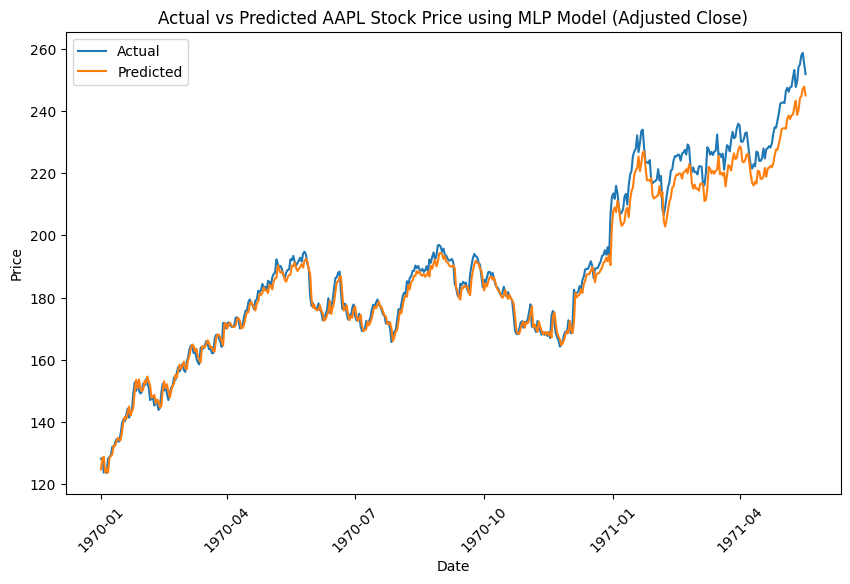

In [70]:
# Validation plot
plt.figure(figsize=(10, 6))
plt.plot(test.index, y_test_rescaled, label='Actual')
plt.plot(test.index, y_pred_rescaled, label='Predicted')

# Format the x-axis to show quarterly ticks
plt.gca().xaxis.set_major_locator(mdates.MonthLocator((1,4,7,10)))  # Quarterly ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as Year-Quarter

# Labels and title
plt.title('Actual vs Predicted AAPL Stock Price using MLP Model (Adjusted Close)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Price')
plt.legend()
plt.show()